In [ ]:
pip install keras-tuner


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0626 - val_loss: 0.0026
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0013 - val_l

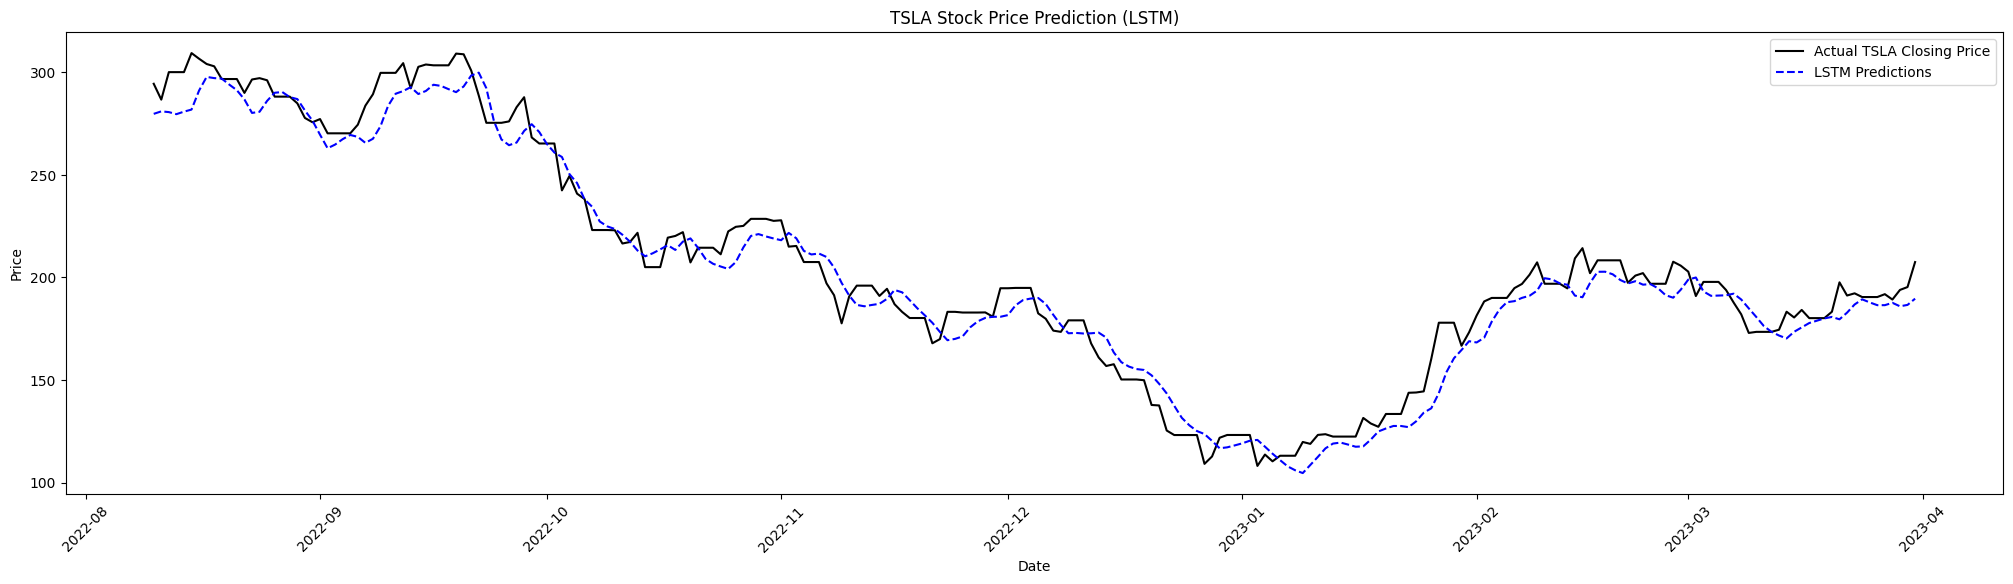

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

file_path = 'dataset.csv'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.sort_values('date').reset_index(drop=True)

encoder = LabelEncoder()
df['news_sentiment'] = encoder.fit_transform(df['news_sentiment'])

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['news_sentiment', 'opening price', 'high', 'low', 'volume traded', 'closing price']])

sequence_length = 20
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])  
    y.append(scaled_data[i, -1])  
X, y = np.array(X), np.array(y)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

def build_lstm_model(hp):
    model = Sequential()

    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=32)))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='lstm_stock_price_prediction'
)

tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps.values}")

best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

lstm_predictions = best_model.predict(X_test).flatten()

lstm_predictions_inverse = scaler.inverse_transform(np.column_stack([np.zeros((len(lstm_predictions), 5)), lstm_predictions]))[:, -1]
real_prices = scaler.inverse_transform(np.column_stack([np.zeros((len(y_test), 5)), y_test]))[:, -1]

mse = mean_squared_error(real_prices, lstm_predictions_inverse)
mae = mean_absolute_error(real_prices, lstm_predictions_inverse)
r2 = r2_score(real_prices, lstm_predictions_inverse)
mape = np.mean(np.abs((real_prices - lstm_predictions_inverse) / real_prices)) * 100
correct_direction = np.sign(np.diff(real_prices)) == np.sign(np.diff(lstm_predictions_inverse))
pocid = np.mean(correct_direction) * 100

print(f'Mean Squared Error (LSTM): {mse}')
print(f'Mean Absolute Error (LSTM): {mae}')
print(f'R2 score (LSTM): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'Percentage of Correct Directional Change (POCID): {pocid}%')

test_dates = df['date'][-len(real_prices):]
plt.figure(figsize=(25, 6))
plt.plot(test_dates, real_prices, color='black', label='Actual TSLA Closing Price')
plt.plot(test_dates, lstm_predictions_inverse, color='blue', linestyle='dashed', label='LSTM Predictions')
plt.title('TSLA Stock Price Prediction (LSTM) with Keras Tuner Hyperparameter Tuning')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step


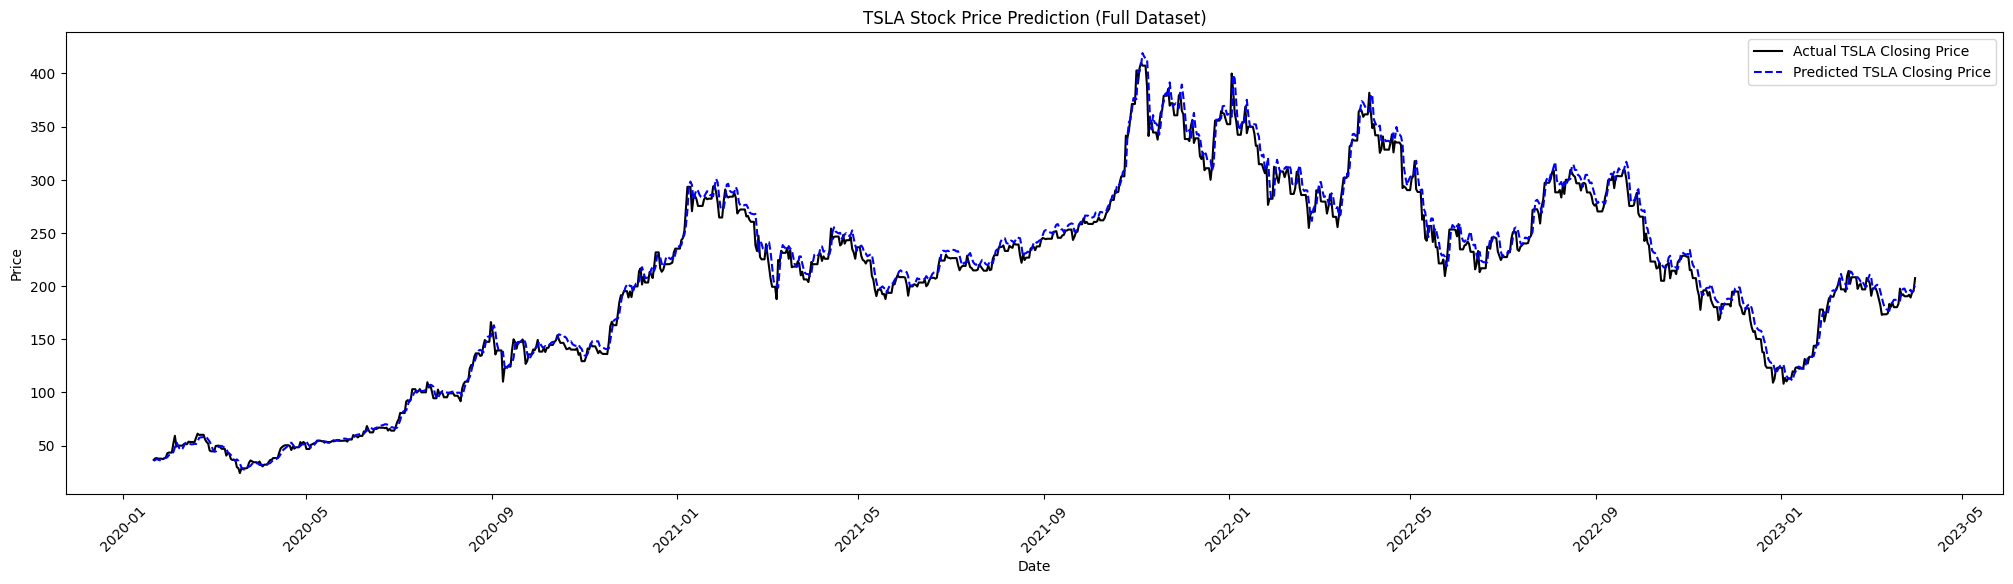

In [ ]:
# Use the entire dataset (including the training data) to make predictions
full_X = []
full_y = []

# Prepare the entire dataset for prediction (like we did for X and y, but for the full data)
for i in range(sequence_length, len(scaled_data)):
    full_X.append(scaled_data[i-sequence_length:i])  # Use last 20 days for each prediction point
    full_y.append(scaled_data[i, -1])  # Next day's closing price (last feature)
full_X, full_y = np.array(full_X), np.array(full_y)

# Make predictions for the entire dataset
full_predictions = model.predict(full_X)

# Inverse scaling for the full dataset predictions and actual values
full_predictions_inverse = scaler.inverse_transform(np.column_stack([np.zeros((len(full_predictions), 5)), full_predictions]))[:, -1]
full_real_prices = scaler.inverse_transform(np.column_stack([np.zeros((len(full_y), 5)), full_y]))[:, -1]

# Plot the actual and predicted values for the entire dataset
plt.figure(figsize=(25, 6))
plt.plot(df['date'][sequence_length:], full_real_prices, color='black', label='Actual TSLA Closing Price')
plt.plot(df['date'][sequence_length:], full_predictions_inverse, color='blue', linestyle='dashed', label='Predicted TSLA Closing Price')
plt.title('TSLA Stock Price Prediction (Full Dataset)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()
